In [1]:
import numpy as np
import gym
import cv2
import pickle
import time
from matplotlib import pyplot as plt
print("Numpy Version:\t\t", np.__version__)
print("OpenAI Gym Version:\t", gym.__version__)
print("OpenCV Version:\t\t", cv2.__version__)

Numpy Version:		 1.17.4
OpenAI Gym Version:	 0.17.1
OpenCV Version:		 4.2.0


In [22]:
hidden_layer_neurons = 200
batch_size = 10
learning_rate = 1e-4
discount_factor = 0.99
rms_decay_rate = 0.99
input_dim = 75 * 80
save_every = 20
LOAD_FILENAME = 'model_np.pkl'
SAVE_FILENAME = 'model_np.pkl'

In [5]:
resume = True # Change to true if training on saved file
render = False  # Render the gym env

In [23]:
model = {
    #     Xavier" initialization
    'W1': np.random.randn(hidden_layer_neurons,input_dim) / np.sqrt(input_dim),
    'W2': np.random.randn(hidden_layer_neurons) / np.sqrt(hidden_layer_neurons)
}
if resume:
    model = pickle.load(open(LOAD_FILENAME, 'rb'))

In [24]:
# RMS PROP variables
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

In [25]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

def relu(x):
    x[x < 0] = 0
    return x

In [26]:
def downsample(img):
    # Choose alternate pixels
    return img[::2, ::2, :]

def remove_background(img):
    img[img == 144] = 0
    img[img == 109] = 0
    return img

def remove_color(img):
    # Take only red color = 0th dim
    return img[:, :, 0]

def crop_playarea(img):
    return img[35:185]

def set_ball_bar_1(img):
    img[img != 0] = 1
    return img

def preprocessing(img):
    img = crop_playarea(img)
    img = downsample(img)
    img = remove_color(img)
    img = remove_background(img)
    img = set_ball_bar_1(img)
    return img.astype(np.float32).ravel()

In [27]:
def policy_forward(x):
    x1 = relu(np.dot(model['W1'], x))
    prob = sigmoid(np.dot(model['W2'], x1))
    return prob, x1

In [28]:
def policy_backward(h, dlogp, x):
    dW2 = np.dot(h.T, dlogp).ravel()
    dh = np.outer(dlogp, model['W2'])
    dh[h <= 0] = 0
    dW1 = np.dot(dh.T, x)
    return {'W1': dW1, 'W2': dW2}

In [29]:
def discount_rewards(rewards):
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    rewards_mul = 0.0
    for i in reversed(range(0, rewards.size)):
        if(rewards[i] != 0):
            # At boundary
            rewards_mul = 0.0
        rewards_mul = rewards_mul * discount_factor + rewards[i]
        discounted_rewards[i] = rewards_mul
    return discounted_rewards

In [30]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None
episode_x,episode_hidden_states,dlogps,drewards = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

In [31]:
running_rewards_list = []
rewards_sum_list = []
batch_time_list = []

In [32]:
max_episodes = 2500
batch_start = time.time()
total_start = time.time()
while episode_number < max_episodes:
    start = time.time()
    if render:
        env.render()
    cur_x = preprocessing(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(input_dim)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, hidden_state = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    episode_x.append(x) # observation
    episode_hidden_states.append(hidden_state) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drewards.append(reward) # record reward (has to be done after we call step() to get reward for previous action)
    
    if done:
        print("Episode ", episode_number, end=":\t")
        episode_number += 1
        epx = np.vstack(episode_x)
        eph = np.vstack(episode_hidden_states)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drewards)
        episode_x,episode_hidden_states,dlogps,drewards = [],[],[],[] # reset array memory
        
        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
        
        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp, epx)
        for layer in model:
            grad_buffer[layer] += grad[layer] # accumulate grad over batch
        
        # Here RMS PROP does the MAGICCCC
        
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        end = time.time()
        print('Resetting env. episode reward total was %f. running mean: %f. time elapsed: %f s' % (reward_sum, running_reward, end-start))

        if episode_number and (episode_number % batch_size == 0):
            for layer, value in model.items():
                delta = grad_buffer[layer]
                rmsprop_cache[layer] = rms_decay_rate * rmsprop_cache[layer] + (1 - rms_decay_rate) * delta ** 2
                model[layer] += learning_rate * delta / (np.sqrt(rmsprop_cache[layer]) + 1e-5)
                grad_buffer[layer] = np.zeros_like(value)
            batch_end = time.time()
            batch_time_list.append(batch_end - batch_start)
            print("\t\tBatch %d Completed in %f s" % (episode_number / batch_size, batch_end - batch_start))
            batch_start = time.time()

        if episode_number and (episode_number % save_every == 0):
            pickle.dump(model, open(SAVE_FILENAME, 'wb'))
            print("\t\tSaved to file:", SAVE_FILENAME)

        running_rewards_list.append(running_reward)
        rewards_sum_list.append(reward_sum)
        
        reward_sum = 0
        observation = env.reset()
        prev_img = None
        
total_end = time.time()
print("Completed in %f s" % (total_end - total_start))
env.close()

KeyboardInterrupt: 

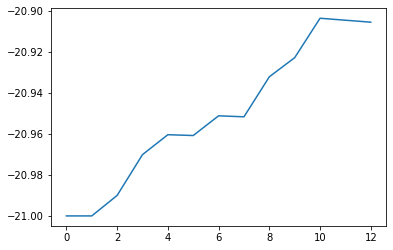

In [117]:
plt.plot(running_rewards_list)

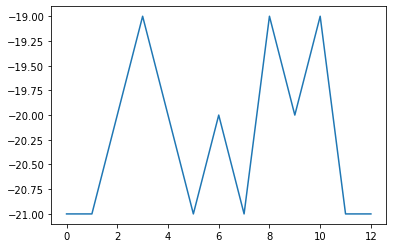

In [118]:
plt.plot(rewards_sum_list)

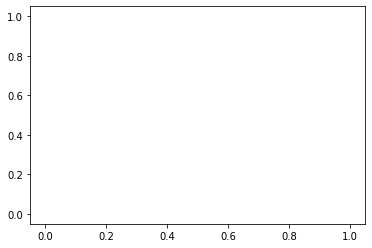

In [90]:
plt.plot(batch_time_list)

In [ ]:
records = {
    'rewards_sum_list': rewards_sum_list,
    'batch_time_list': batch_time_list,
    'running_rewards_list': running_rewards_list
}
pickle.dump(records, open('record_data.pkl', 'wb'))

## References:
- [Deep Reinforcement Learning: Pong from Pixels](https://karpathy.github.io/2016/05/31/rl/) - Andrej Karpathy
- [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) - Sutton and Barto

In [17]:
records = pickle.load(open('record_data-1.pkl', 'rb'))

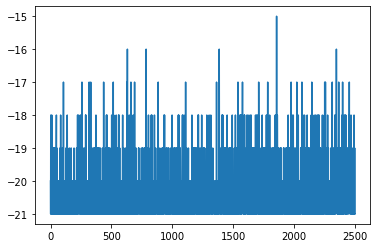

In [18]:
plt.plot(records['rewards_sum_list'])

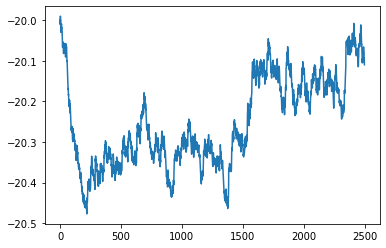

In [19]:
plt.plot(records['running_rewards_list'])

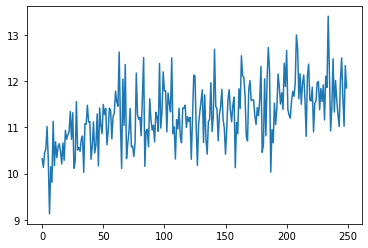

In [20]:
plt.plot(records['batch_time_list'])

In [21]:
np.mean(records['running_rewards_list'])

-20.251265441492258